# Style Transfer:- Alchemists's Implementation of Gatys's Paper

### Prelimnaries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load Content and Style Images

In [3]:
def img_to_tensor(image_name, img_size):
    '''
    Converts an image to a tensor after resizing.
    Inputs:-
            image_name - path of the image to be converted.
            img_size - size to be resized to.
            
    Returns:-
            image - the tensor equivalent of the image.
    '''
    
    image = Image.open(image_name)
    img_transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])
    
    # VGG19 is written such that the input's dimension should be batch (B) x channel (C) x height (H) x width (W)
    # So put an extra (batch) dimension.
    image = img_transform(image).unsqueeze(0)
    
    return image.to(device, torch.float)

In [4]:
img_size = 512 if torch.cuda.is_available() else 128
style_img = img_to_tensor("./Images/Starry_Night.jpg", img_size)
content_img = img_to_tensor("./Images/castle_jpg.jpg", img_size)

### Display Images

In [5]:
def myimshow(image, ax=plt, title=None):
    '''
    Displays an image.
    Inputs:-
            image - the image to be displayed.
            ax - axes handle to be used incase of multiple subplots.
            title - string containing the title of the image.
    
    Returns:-
            h - the image handle.
            
    '''
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')               # Comment this line to see the image size
    return h

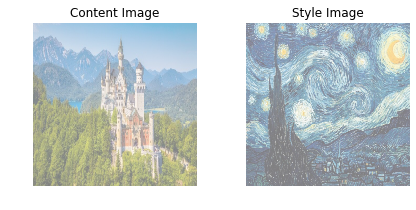

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
myimshow(content_img[0], axes[0], title='Content Image')
myimshow(style_img[0], axes[1], title='Style Image')

### Define the Class for Content Loss

In [7]:
class ContentLoss(nn.Module):
    '''
    Defines a Content Loss Module. Inherits from nn.Module
    
    Arguments:-
            target_content - the target content image on which the content loss should be calculated
    '''

    def __init__(self, target_content):
        super(ContentLoss, self).__init__()
        # We don't need to compute the gradients w.r.t the content target.
        self.target = target_content.detach()

    def forward(self, input):
        '''
        Calculates the Content Loss between the target image and the input.
        
        Inputs:- 
                input - the input image.
                
        Returns:-
                input - the input image. (so that it can be used for the next layer)
        '''
        
        self.loss = F.mse_loss(input, self.target)
        
        return input

### Define function for computing Gram Matrix

In [8]:
def GramMatrix(input):
    '''
    Computes the Gram Matrix for a given input image.
    
    Inputs:-
            input - the input image.
            
    Outputs:-
            G - the (normalized) Gram Matrix.
    '''
    
    a, b, c, d = input.size()  
    # a - Batch Size, b - Number of Feature Maps
    # c - Height of a Feature Map, d - Widht of a feature map

    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())  # Gram matrix (shape = ab x ab)

    # Normalize by the number of elements in each feature map.
    return G.div(a * b * c * d)

### Define the Class for Style Loss

In [9]:
class StyleLoss(nn.Module):
    '''
    Defines a Style Loss Module. Inherits from nn.Module
    
    Arguments:-
            target_style - the target style image on which the style loss should be calculated.
    '''
    
    def __init__(self, target_style):
        super(StyleLoss, self).__init__()
        # We don't need to compute the gradients w.r.t the style target.
        self.target = GramMatrix(target_style).detach()

    def forward(self, input):
        '''
        Calculates the Style Loss between the target image and the input.
        
        Inputs:- 
                input - the input image.
                
        Returns:-
                input - the input image. (so that it can be used for the next layer).
        '''
        
        G = GramMatrix(input)
        self.loss = F.mse_loss(G, self.target)
        
        return input

### VGG Model

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
# print(cnn)

In [11]:
class Normalization(nn.Module):
    '''
    Defines a Normalization module.
    
    Arguments:- 
            mean - the normalization mean. 
            std_dev - the normalization standard deviation.
    '''

    def __init__(self, mean, std_dev):
        super(Normalization, self).__init__()
        # Reshaping them here so that they can work with the 4D tensors.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std_dev).view(-1, 1, 1)

    def forward(self, img):
        '''
        Normalizes the input image with the passed mean and standard deviation.
        
        Inputs:-
                img - the input image.
        
        Returns:-
                the normalized image.
        '''
        
        return (img - self.mean) / self.std

In [12]:
def GetModel(vgg_net, norm_mean, norm_std, style_img, content_img, style_layers, content_layers,
            pool_flag = 'maxpool'):
    '''
    Function to generate the truncated VGG network used for style transfer.

    Inputs:-
            vgg_net - the original VGG network.
            norm_mean - the mean used for normalization.
            norm_std - the standard deviation used for normalization.
            style_img - the style image.
            content_img - the content image.
            style_layers - a list of all the layers at which style loss should be calculated.
            content_layers - a list of all the layers at which content loss should be calculated.
            pool_flag - a flag to decide whether to use MaxPool (pass 'maxpool') or AvgPool (pass 'avgpool')
    
    Returns:-
            model - the truncated VGG network.
            style_losses - list of style loss objects.
            content_losses - list of content loss objects.
    '''
    
    # Might modify the original net, so make a copy just to be safe.
    net_copy = copy.deepcopy(vgg_net)

    # Check whether you need to use max/avg pool.
    # Max pool is slightly faster than avgpool.
    if(pool_flag == 'avgpool'):
        for i in range(len(net_copy)):
            if isinstance(net_copy[i], nn.MaxPool2d):
                net_copy[i] = nn.AvgPool2d(kernel_size=2, stride=2)
            
    normalization = Normalization(norm_mean, norm_std)

    # List of losses
    content_losses = []
    style_losses = []

    # Create a sequential object for the net.
    # When the object is used, the forward method is called sequentially
    # for all the modules automatically.
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a convolution layer
    for layer in net_copy.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
            
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        
        elif isinstance(layer, nn.MaxPool2d) or isinstance(layer, nn.AvgPool2d):
            name = 'pool_{}'.format(i)
        
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # So far, we've given names to all layers.
    # We need to have only the layers which are calculating the losses.
    # So keep those and remove the rest.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [13]:
# # Check whether the net has the correct architecture
# # Set the mean, std dev, content and style layers.
# test_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
# test_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
# test_content = ['relu_4']
# test_style = ['relu_1', 'relu_2', 'relu_3', 'relu_4', 'relu_5']

# net, st_ls, ct_ls = GetModel(cnn, test_mean, test_std, style_img, content_img,
#                              content_layers=test_content,
#                              style_layers=test_style)
# print(net)

In [14]:
def GetOptimizer(trainable_param):
    '''
    Function to get optimizer.
    
    Inputs:-
            trainable_param - the tensor which requires gradient 
                            (the gradient of the loss will be computed w.r.t these values).
                            
    Returns:-
            optimizer - the optimizer with the required parameters set.
    '''
    
    # No optimizer was mentioned in the paper, but since the Fast Style Transfer paper uses LBFGS,
    # we use that here too. Adam with lr=1e-3 is faster than LBFGS, but LBFGS has better convergence.
    # We use a lr=1e-1 in LBFGS to avoid getting stuck at local optima. (This value was arrived at after tuning.)
    # We must calculate the gradient w.r.t the input image because that is what we will be updating.
    
    optimizer = optim.LBFGS([trainable_param.requires_grad_()], lr=1e-1)
#     optimizer = optim.Adam([trainable_param.requires_grad_()], lr=1e-3)
    
    return optimizer

In [15]:
def StyleTransfer(vgg_net, norm_mean, norm_std,
                  content_img, style_img, input_img,
                  content_layers, style_layers,
                  pooling='maxpool', num_iters=300,
                  style_weight=1000000, content_weight=1,
                  print_freq=10):
    '''
    Function to run the style transfer.

    Inputs:-
            vgg_net - the original VGG network.
            norm_mean - the mean used for normalization.
            norm_std - the standard deviation used for normalization.
            content_img - the content image.
            style_img - the style image.
            input_img - the input image.
            content_layers - a list of all the layers at which content loss should be calculated.
            style_layers - a list of all the layers at which style loss should be calculated.
            pooling - a flag to decide whether to use MaxPool (pass 'maxpool') or AvgPool (pass 'avgpool')
            num_iters - number of iterations.
            style_weight - penalizing factor for style loss.
            content_weight - penalizing factor for content loss.
            print_freq - frequency at which losses should be printed.
    
    Returns:-
            input_img - the transformed image.
    '''
        
    model, style_losses, content_losses = GetModel(vgg_net, norm_mean, norm_std, style_img, content_img,
                                                   style_layers, content_layers, pool_flag=pooling)

    optimizer = GetOptimizer(input_img)
    
    print('Model Built. Optimization in Progress...')
    
    run = [0]
    
    while run[0] <= num_iters:
            
        def closure():
        
            # Not required but we ensure that our tensor values are in [0,1]. 
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            tot_style_loss = 0
            tot_content_loss = 0

            for loss in style_losses:
                tot_style_loss += loss.loss
                
            for loss in content_losses:
                tot_content_loss += loss.loss

            tot_style_loss *= style_weight
            tot_content_loss *= content_weight

            total_loss = tot_style_loss + tot_content_loss
                
            total_loss.backward()
 
            if run[0] % print_freq == 0:
                print("Iteration {}:- ".format(run[0]))
                print('Style Loss = {:4f} Content Loss = {:4f}\n'.format(
                    tot_style_loss.item(), tot_content_loss.item()))
                
                cost_curves_filename = "./gatys_artifacts/loss_details_per_iter_rand_ip.txt"
                
                loss_dict = {"epoch":run[0],
                             "agg_content_loss": tot_content_loss.item()/print_freq,
                             "agg_style_loss": tot_style_loss.item()/print_freq,
                             "total_loss": (tot_content_loss.item()+tot_style_loss.item() )/print_freq}
                
                with open(cost_curves_filename,"a") as f:             
                    f.write(str(loss_dict)+"\n")
            
            run[0] += 1
            
            return total_loss

        optimizer.step(closure)
        
    # We need an image, so clamp all values to lie in [0,1].
    input_img.data.clamp_(0, 1)

    return input_img

### Training

In [16]:
# Train and get the output
train_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
train_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

train_content = ['relu_4']
train_style = ['relu_1', 'relu_2', 'relu_3', 'relu_4', 'relu_5']
style_weight = 1e6
content_weight = 1

# Training time is roughly 20s per 300 iterations. Change accordingly.
iterations = 3000

# To avoid manipulating the original image, copy it and use the copy
# input_img = content_img.clone().detach()

# You could use the original image as the input.
# But to see the magic, input a tensor with random values.
# If the learning is too fast, you could decrease the LBFGS learning rate.

input_img = torch.rand_like(content_img, device=device)
orig = input_img.clone().detach()
    
result = StyleTransfer(cnn, train_mean, train_std,
                       content_img, style_img, input_img,
                       train_content, train_style,
                       style_weight=style_weight, content_weight=content_weight,
                       num_iters=iterations, print_freq=iterations//10, pooling='avgpool')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Model Built. Optimization in Progress...
Iteration 0:- 
Style Loss = 2983.823975 Content Loss = 8.434007

Iteration 300:- 
Style Loss = 5.162433 Content Loss = 2.140070

Iteration 600:- 
Style Loss = 0.195184 Content Loss = 1.350484

Iteration 900:- 
Style Loss = 0.160989 Content Loss = 1.283993

Iteration 1200:- 
Style Loss = 0.236860 Content Loss = 1.407124

Iteration 1500:- 
Style Loss = 2.399052 Content Loss = 1.451466

Iteration 1800:- 
Style Loss = 0.205662 Content Loss = 1.541335

Iteration 2100:- 
Style Loss = 228.080322 Content Loss = 4.738937

Iteration 2400:- 
Style Loss = 0.810995 Content Loss = 3.132700

Iteration 2700:- 
Style Loss = 32.686268 Content Loss = 3.833385

Iteration 3000:- 
Style Loss = 0.473972 Content Loss = 1.306477



### Output

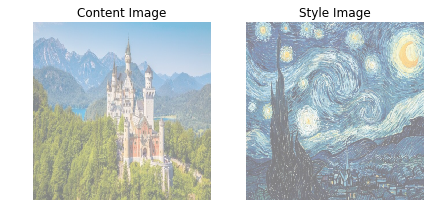

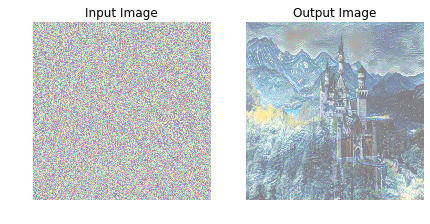

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 6))
myimshow(content_img[0], axes[0], title='Content Image')
myimshow(style_img[0], axes[1], title='Style Image')

fig, axes = plt.subplots(ncols=2, figsize=(7, 6))
myimshow(orig[0], axes[0], title='Input Image')
myimshow(result[0], axes[1], title='Output Image')